# Multi-armed Bandit for Banner Ad

> Multi-armed Bandit for Banner Ad and 4 Exploration Strategies

## Setup

### Installations

In [ ]:
# !pip install gym==0.7.4

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gym
from gym import spaces
from gym.utils import seeding
# from gym.scoreboard.registration import add_task, add_group

from gym.envs.registration import register

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

### Environments

- `BanditTwoArmedDeterministicFixed-v0`: Simplest case where one bandit always pays, and the other always doesn't. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = [1, 0]
    - r_dist = [1, 1]
- `BanditTwoArmedHighLowFixed-v0`: Stochastic version with a large difference between which bandit pays out of two choices. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = [0.8, 0.2]
    - r_dist = [1, 1]
- `BanditTwoArmedHighHighFixed-v0`: Stochastic version with a small difference between which bandit pays where both are good. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = [0.8, 0.9]
    - r_dist = [1, 1]
- `BanditTwoArmedLowLowFixed-v0`: Stochastic version with a small difference between which bandit pays where both are bad. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = [0.1, 0.2]
    - r_dist = [1, 1]
- `BanditTenArmedRandomFixed-v0`: 10 armed bandit with random probabilities assigned to payouts. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = numpy.random.uniform(size=10)
    - r_dist = numpy.full(bandits, 1)
    - Bandits have a uniform probability of rewarding and always reward 1
- `BanditTenArmedRandomRandom-v0`: 10 armed bandit with random probabilities assigned to both payouts and rewards. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = numpy.random.uniform(size=10)
    - r_dist = numpy.random.uniform(size=10)
    - Bandits have uniform probability of paying out and payout a reward of uniform probability
- `BanditTenArmedUniformDistributedReward-v0`: 10 armed bandit with that always pays out with a reward selected from a uniform distribution. Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded  the bandit does payout.
    - p_dist = numpy.full(bandits, 1)
    - r_dist = numpy.random.uniform(size=10)
    - Bandits always pay out. Reward is selected from uniform distribution
- `BanditTenArmedGaussian-v0`: 10 armed bandit mentioned on page 30 of [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0) (Sutton and Barto). Each bandit takes in a probability distribution, which is the likelihood of the action paying out, and a reward distribution, which is the value or distribution of what the agent will be rewarded the bandit does payout.
    - p_dist = [1] (* 10)
    - r_dist = [numpy.random.normal(0, 1), 1] (* 10)
    - Every bandit always pays out
    - Each action has a reward mean (selected from a normal distribution with mean 0 and std 1), and the actual reward returns is selected with a std of 1 around the selected mean.

In [ ]:
class BanditEnv(gym.Env):
    """
    Bandit environment base to allow agents to interact with the class n-armed bandit
    in different variations
    p_dist:
        A list of probabilities of the likelihood that a particular bandit will pay out
    r_dist:
        A list of either rewards (if number) or means and standard deviations (if list)
        of the payout that bandit has
    """
    def __init__(self, p_dist, r_dist):
        if len(p_dist) != len(r_dist):
            raise ValueError("Probability and Reward distribution must be the same length")

        if min(p_dist) < 0 or max(p_dist) > 1:
            raise ValueError("All probabilities must be between 0 and 1")

        for reward in r_dist:
            if isinstance(reward, list) and reward[1] <= 0:
                raise ValueError("Standard deviation in rewards must all be greater than 0")

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.n_bandits = len(p_dist)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.observation_space = spaces.Discrete(1)

        self._seed()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)

        reward = 0
        done = True

        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward = self.r_dist[action]
            else:
                reward = np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        return 0, reward, done, {}

    def reset(self):
        return 0

    def render(self, mode='human', close=False):
        pass


class BanditTwoArmedDeterministicFixed(BanditEnv):
    """Simplest case where one bandit always pays, and the other always doesn't"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[1, 0], r_dist=[1, 1])


class BanditTwoArmedHighLowFixed(BanditEnv):
    """Stochastic version with a large difference between which bandit pays out of two choices"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.8, 0.2], r_dist=[1, 1])


class BanditTwoArmedHighHighFixed(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are good"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.8, 0.9], r_dist=[1, 1])


class BanditTwoArmedLowLowFixed(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are bad"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.1, 0.2], r_dist=[1, 1])


class BanditTenArmedRandomFixed(BanditEnv):
    """10 armed bandit with random probabilities assigned to payouts"""
    def __init__(self, bandits=10):
        p_dist = np.random.uniform(size=bandits)
        r_dist = np.full(bandits, 1)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedUniformDistributedReward(BanditEnv):
    """10 armed bandit with that always pays out with a reward selected from a uniform distribution"""
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = np.random.uniform(size=bandits)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedRandomRandom(BanditEnv):
    """10 armed bandit with random probabilities assigned to both payouts and rewards"""
    def __init__(self, bandits=10):
        p_dist = np.random.uniform(size=bandits)
        r_dist = np.random.uniform(size=bandits)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedGaussian(BanditEnv):
    """
    10 armed bandit mentioned on page 30 of Sutton and Barto's
    [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0)
    Actions always pay out
    Mean of payout is pulled from a normal distribution (0, 1) (called q*(a))
    Actual reward is drawn from a normal distribution (q*(a), 1)
    """
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = []

        for _ in range(bandits):
            r_dist.append([np.random.normal(0, 1), 1])

        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)

## Create the Bandit environment in Gym

In [ ]:
register(
    id='BanditTwoArmedHighLowFixed-v0',
    entry_point='__main__:BanditTwoArmedHighLowFixed',
)

In [ ]:
#Let's just create a simple 2-armed bandit whose environment ID is BanditTwoArmedHighLowFixed-v0:
env = gym.make("BanditTwoArmedHighLowFixed-v0")

# Since we created a 2-armed bandit, our action space will be 2 (as there are two arms), as shown here:
print(env.action_space.n)    # The preceding code will print: 2

# We can also check the probability distribution of the arm with:
print(env.p_dist) 

[2021-10-20 14:19:45,784] Making new env: BanditTwoArmedHighLowFixed-v0


2
[0.8, 0.2]


## $\epsilon$-Greedy

> Find the best bandit arm with Epsilon-Greedy method

In [ ]:
# First, let's initialize the variables.
# Initialize the count for storing the number of times an arm is pulled:
count = np.zeros(2)

# Initialize sum_rewards for storing the sum of rewards of each arm:
sum_rewards = np.zeros(2)

# Initialize Q for storing the average reward of each arm:
Q = np.zeros(2)

# Set the number of rounds (iterations):
num_rounds = 100


# Now, let's define the epsilon_greedy function.
def epsilon_greedy(epsilon):
    """First, we generate a random number from a uniform distribution. If the random 
    number is less than epsilon, then we pull the random arm; else, we pull 
    the best arm that has the maximum average reward"""

    if np.random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q)


# Now, let's play the game and try to find the best arm using the epsilon-greedy method.
# For each round:
for i in range(num_rounds):
  # Select the arm based on the epsilon-greedy method:
  arm = epsilon_greedy(epsilon=0.5)
  # Pull the arm and store the reward and next state information:
  next_state, reward, done, info = env.step(arm)
  # Increment the count of the arm by 1:
  count[arm] += 1
  # Update the sum of rewards of the arm:
  sum_rewards[arm]+=reward
  # Update the average reward of the arm:
  Q[arm] = sum_rewards[arm]/count[arm]
  
# After all the rounds, we look at the average reward obtained from each of the arms:
print(Q)    # The preceding code will print something like this: [0.xx 0.yy]

# Now, we can select the optimal arm as the one that has the maximum average reward:
print('The optimal arm is arm {}'.format(np.argmax(Q)+1))

[0.80263158 0.33333333]
The optimal arm is arm 1


## Softmax

> Find the best bandit arm with Softmax method.

We define the softmax function with the temperature T:

$$\large P_i=\frac{e^{\frac{y_i}T}}{\sum_{k=1}^n e^{\frac{y_k}T}}$$

In [ ]:
# First, let's initialize the variables.
# Initialize the count for storing the number of times an arm is pulled:
count = np.zeros(2)

# Initialize sum_rewards for storing the sum of rewards of each arm:
sum_rewards = np.zeros(2)

# Initialize Q for storing the average reward of each arm:
Q = np.zeros(2)

# Set the number of rounds (iterations):
num_rounds = 100


# Now, we define the softmax function with the temperature T:
def softmax(T):
  # Compute the probability of each arm based on the temperature equation:
  denom = sum([np.exp(i/T) for i in Q])
  probs = [np.exp(i/T)/denom for i in Q]
  # Select the arm based on the computed probability distribution of arms:
  arm = np.random.choice(env.action_space.n, p=probs)  
  return arm


# Now, let's play the game and try to find the best arm using the softmax exploration method.
# Let's begin by setting the temperature T to a high number, say, 50:
T = 50
# For each round:
for i in range(num_rounds):
  # Select the arm based on the softmax exploration method:
  arm = softmax(T)
  # Pull the arm and store the reward and next state information:
  next_state, reward, done, info = env.step(arm)
  # Increment the count of the arm by 1:
  count[arm] += 1
  # Update the sum of rewards of the arm:
  sum_rewards[arm]+=reward
  # Update the average reward of the arm:
  Q[arm] = sum_rewards[arm]/count[arm]
  # Reduce the temperature T:
  T = T*0.99

# After all the rounds, we check the Q value, that is, the average reward of all the arms:
print(Q)    # The preceding code will print something like this: [0.xx 0.yy]

# Now, we can select the optimal arm as the one that has the maximum average reward:
print('The optimal arm is arm {}'.format(np.argmax(Q)+1))

[0.80392157 0.20408163]
The optimal arm is arm 1


## UCB

> Find the best bandit arm with Upper Confidence Bound method
    
The algorithm of UCB is given as follows:
    
1. Select the arm whose upper confidence bound is high
2. Pull the arm and receive a reward
3. Update the arm's mean reward and confidence interval
4. Repeat *steps 1* to *3* for several rounds
    

Let N(a) be the number of times arm a was pulled and t be the total number of rounds, then the upper confidence bound of arm a can be computed as:

$$A_t \dot{=} \operatorname{argmax}_a \left[ Q_t(a) + c \sqrt{ \frac{\ln t}{N_t(a)} } \right]$$

In [ ]:
# First, let's initialize the variables.
# Initialize the count for storing the number of times an arm is pulled:
count = np.zeros(2)

# Initialize sum_rewards for storing the sum of rewards of each arm:
sum_rewards = np.zeros(2)

# Initialize Q for storing the average reward of each arm:
Q = np.zeros(2)

# Set the number of rounds (iterations):
num_rounds = 100

# Now, we define the UCB function, which returns the best arm as the 
# one that has the highest UCB:
def UCB(i):
  # Initialize the numpy array for storing the UCB of all the arms:
  ucb = np.zeros(2)
  # Before computing the UCB, we explore all the arms at least once, so for the 
  # first 2 rounds, we directly select the arm corresponding to the round number:
  if i < 2:
    return i
  # If the round is greater than 2, then we compute the UCB of all the arms as 
  # specified in the UCB equation and return the arm that has the highest UCB:
  else:
    for arm in range(2):
      ucb[arm] = Q[arm] + np.sqrt((2*np.log(sum(count))) / count[arm])
  return (np.argmax(ucb))

# Now, let's play the game and try to find the best arm using the UCB method.
# For each round:
for i in range(num_rounds):
  # Select the arm based on the UCB method:
  arm = UCB(i)
  # Pull the arm and store the reward and next state information:
  next_state, reward, done, info = env.step(arm)
  # Increment the count of the arm by 1:
  count[arm] += 1
  # Update the sum of rewards of the arm:
  sum_rewards[arm]+=reward
  # Update the average reward of the arm:
  Q[arm] = sum_rewards[arm]/count[arm]

# Now, we can select the optimal arm as the one that has the maximum average reward:
print('The optimal arm is arm {}'.format(np.argmax(Q)+1))

The optimal arm is arm 1


## TS

> Find the best bandit arm with Thompson Sampling method
    
The steps involved in the Thomson sampling method are given here:

1. Initialize the beta distribution with alpha and beta set to equal values for all *k* arms
2. Sample a value from the beta distribution of all *k* arms
3. Pull the arm whose sampled value is high
4. If we win the game, then update the alpha value of the distribution to $\alpha = \alpha + 1$
5. If we lose the game, then update the beta value of the distribution to $\beta = \beta + 1$
6. Repeat steps 2 to *5* for many rounds

In [ ]:
# First, let's initialize the variables.
# Initialize the count for storing the number of times an arm is pulled:
count = np.zeros(2)

# Initialize sum_rewards for storing the sum of rewards of each arm:
sum_rewards = np.zeros(2)

# Initialize Q for storing the average reward of each arm:
Q = np.zeros(2)

# Initialize the alpha value as 1 for both arms:
alpha = np.ones(2)

# Initialize the beta value as 1 for both arms:
beta = np.ones(2)

# Set the number of rounds (iterations):
num_rounds = 100


# Now, let's define the thompson_sampling function
def thompson_sampling(alpha,beta):
  """we randomly sample values from the beta distributions of both arms and 
  return the arm that has the maximum sampled value"""
  samples = [np.random.beta(alpha[i]+1,beta[i]+1) for i in range(2)]
  return np.argmax(samples)


# Now, let's play the game and try to find the best arm using the Thompson sampling method.
# For each round:
for i in range(num_rounds):
  # Select the arm based on the Thompson sampling method:
  arm = thompson_sampling(alpha,beta)
  # Pull the arm and store the reward and next state information:
  next_state, reward, done, info = env.step(arm) 
  # Increment the count of the arm by 1:
  count[arm] += 1
  # Update the sum of rewards of the arm:
  sum_rewards[arm]+=reward
  # Update the average reward of the arm:
  Q[arm] = sum_rewards[arm]/count[arm]
  # If we win the game, that is, if the reward is equal to 1, then we update 
  # the value of alpha to alpha+1, else we update the value of beta to beta+1:
  if reward==1:
    alpha[arm] = alpha[arm] + 1
  else:
    beta[arm] = beta[arm] + 1

# After all the rounds, we can select the optimal arm as the one that has the highest average reward:
print('The optimal arm is arm {}'.format(np.argmax(Q)+1))

The optimal arm is arm 1


## Finding the best advertisement banner using bandits

Bandits can be used as an alternative to AB testing. AB testing is one of the most commonly used classic methods of testing. Say we have two versions of the landing page of our website. Suppose we want to know which version of the landing page is most liked by the users. In this case, we conduct AB testing to understand which version of the landing page is most liked by the users. So, we show version 1 of the landing page to a particular set of users and version 2 of the landing page to other set of users. Then we measure several metrics, such as click-through rate, average time spent on the website, and so on, to understand which version of the landing page is most liked by the users. Once we understand which version of the landing page is most liked by the users, then we will start showing that version to all the users.

Thus, in AB testing, we schedule a separate time for exploration and exploitation. That is, AB testing has two different dedicated periods for exploration and exploitation. But the problem with AB testing is that it will incur high regret. We can minimize the regret using the various exploration strategies that we have used to solve the MAB problem. So, instead of performing complete exploration and exploitation separately, we can perform exploration and exploitation simultaneously in an adaptive fashion with the various exploration strategies

Suppose we are running a website and we have five different banners for a single advertisement on our website and say we want to figure out which advertisement banner is most liked by the users. We can frame this problem as a MAB problem. The five advertisement banners represent the five arms of the bandit, and we assign +1 reward if the user clicks the advertisement and 0 rewards if the user does not click the advertisement. So, to find out which advertisement banner is most clicked by the users, that is, which advertisement banner can give us the maximum reward, we can use various exploration strategies.

In [ ]:
# Creating a dataset
# We generate a dataset with five columns denoting the five advertisement banners, 
# where the values in the rows will be either 0 or 1, indicating whether the 
# advertisement banner has been clicked (1) or not clicked (0) by the user:
df = pd.DataFrame()

for i in range(5):
  df['Banner_type_'+str(i)] = np.random.randint(0,2,100000)

# Now, let's initialize some of the important variables.
# Set the number of iterations:
num_iterations = 100000

# Define the number of banners:
num_banner = 5

# Initialize count for storing the number of times the banner was clicked:
count = np.zeros(num_banner)

# Initialize sum_rewards for storing the sum of rewards obtained from each banner:
sum_rewards = np.zeros(num_banner)

# Initialize Q for storing the mean reward of each banner:
Q = np.zeros(num_banner)

# Define a list for storing the selected banners:
banner_selected = []


# Now, let's define the epsilon-greedy method:
def epsilon_greedy_policy(epsilon):
  if np.random.uniform(0,1) < epsilon:
    return np.random.choice(num_banner)
  else:
    return np.argmax(Q)

# Now, we run the epsilon-greedy policy to find out which advertisement banner is the best.
# For each iteration:
for i in range(num_iterations):
  # Select the banner using the epsilon-greedy policy:
  banner = epsilon_greedy_policy(0.5)
  # Get the reward of the banner:
  reward = df.values[i, banner]
  # Increment the counter:
  count[banner] += 1
  # Store the sum of rewards:
  sum_rewards[banner]+=reward
  # Compute the average reward:
  Q[banner] = sum_rewards[banner]/count[banner]
  # Store the banner to the banner selected list:
  banner_selected.append(banner)

# After all the rounds, we can select the best banner as the one that has the maximum average reward:
print( 'The best banner is banner {}'.format(np.argmax(Q)))

The best banner is banner 4


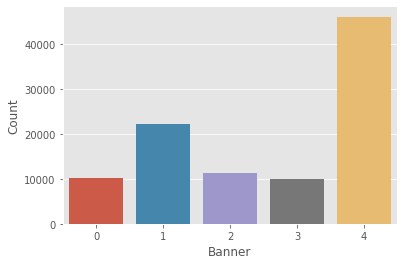

In [ ]:
# We can also plot and see which banner is selected the most often:
ax = sns.countplot(banner_selected)
ax.set(xlabel='Banner', ylabel='Count')
plt.show()

## Contextual bandits

The banner preference varies from user to user. That is, user A likes banner 1, but user B might like banner 3, and so on. Each user has their own preferences. So, we have to personalize advertisement banners according to each user. How can we do that? This is where we use contextual bandits. In the MAB problem, we just perform the action and receive a reward. But with contextual bandits, we take actions based on the state of the environment and the state holds the context. For instance, in the advertisement banner example, the state specifies the user behavior and we will take action (show the banner) according to the state (user behavior) that will result in the maximum reward (ad clicks). Contextual bandits are widely used for personalizing content according to the user's behavior. They are also used to solve the cold-start problems faced by recommendation systems. Netflix uses contextual bandits for personalizing the artwork for TV shows according to user behavior.